In [103]:
import pygame
import random
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import pickle
import os, sys
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [87]:
# set SDL to use the dummy NULL video driver,
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [88]:
# Constants for the game grid
GRID_SIZE = 40
GRID_WIDTH = 10
GRID_HEIGHT = 10

# Define actions
ACTIONS = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Up, Down, Left, Right

# Colors
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)  # Color for the snake's head


In [89]:
class SnakeGame():
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((GRID_WIDTH * GRID_SIZE, GRID_HEIGHT * GRID_SIZE))
        pygame.display.set_caption("Snake Game - RL")
        self.delay_time = 0.000005
        self.reset()

    def get_state(self):
      s = self.snake[0]
      f = self.food

      state_x = s[0] - f[0]
      state_y = s[1] - f[1]

      return (state_x, state_y)

    def reset(self):
        self.food = self.initialize_food()
        self.snake = self.initialize_snake(food = self.food)

    def initialize_food(self):
        empty_cells = [(x, y) for x in range(GRID_WIDTH) for y in range(GRID_HEIGHT)]
        return random.choice(empty_cells)

    def initialize_snake(self, food):
        empty_cells = [(x, y) for x in range(GRID_WIDTH) for y in range(GRID_HEIGHT)]
        empty_cells.remove(food)
        return [random.choice(empty_cells)]

    def is_valid_move(self, action):
        new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])
        #print("new_head[0]", new_head[0] < 0)
        #print("new_head[0]", new_head[0] >= GRID_WIDTH)
        #print("new_head[1]", new_head[1] < 0)
        #print("new_head[1]", new_head[1] >= GRID_HEIGHT)
        #print("new_head in ", new_head in self.snake) # erro esta aqui
        if (
            new_head[0] < 0
            or new_head[0] >= GRID_WIDTH
            or new_head[1] < 0
            or new_head[1] >= GRID_HEIGHT
            or new_head in self.snake
        ):
            return False

        return True

    def step(self, reward_shape, method = 'random', value_function = None):
        reward = 0
        get = False
        # valid_actions = [action for action in ACTIONS if self.is_valid_move(action)]
        # action = random.choice(ACTIONS)
        action = self.get_desired_action(method = method, value_function = value_function)
        is_valid = self.is_valid_move(action)
        while not is_valid:
            #print("Nao e valido")
            action = self.get_desired_action(method = 'random', value_function = value_function)
            reward = -1
            is_valid = self.is_valid_move(action)
            #return reward, True  # No reward and episode ends
        #print("Action Selected", action)
        if self.snake[0] == self.food:
            self.food = self.initialize_food()
            self.snake.append((0, 0))
            reward = reward_shape[1]
            get = True
        else:
            reward = -1
        #elif action != self.get_desired_action():
        #    reward = reward_shape[0]
        new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])

        self.snake.insert(0, new_head)
        self.snake.pop()

        return reward, True, get

    def render(self, render = True):

        if not render:
          return None

        self.screen.fill(WHITE)
        for i, segment in enumerate(self.snake):
            if i == 0:
                pygame.draw.rect(self.screen, BLUE, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
            else:
                pygame.draw.rect(self.screen, GREEN, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
        pygame.draw.rect(self.screen, RED, (self.food[0] * GRID_SIZE, self.food[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
        pygame.display.update()

        #to run in Colab:
        #convert image so it can be displayed in OpenCV
        view = pygame.surfarray.array3d(self.screen)
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
        cv2_imshow(img_bgr)
        time.sleep(self.delay_time)
        output.clear()

    # Optmization that make snake go only to the direction of the food, instead of choosing a random direction
    def get_desired_action(self, method = 'random', value_function = None):
        head = self.snake[0]
        food = self.food
        delta_x = food[0] - head[0]
        delta_y = food[1] - head[1]


        if method == 'best':
          if delta_x > 0:
              return (1, 0)  # Right
          elif delta_x < 0:
              return (-1, 0)  # Left
          elif delta_y > 0:
              return (0, 1)  # Down
          elif delta_y < 0:
              return (0, -1)  # Up
          else:
              return (0, 0)  # No movement


        #choose a random action
        if method  == 'random':
          possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
          idx = np.random.choice([0,1,2,3])
          return possible_actions[idx]

        if method == 'value':

          state = self.get_state()
          possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
          max_value = -np.inf
          for a in possible_actions:

            future_state = (state[0] + a[0], state[1] +a[1])
            if self.is_valid_move(a):
              #print(future_state,state,  self.snake, self.food, value_function[str(future_state)])
              if value_function[str(future_state)] >= max_value:
                f = future_state
                v = value_function[str(future_state)]
                max_value = value_function[str(future_state)]
                action = a

          #print('--', v, f, action)
          return action



In [90]:
class MonteCarloAgent():
    def __init__(self, game, gamma = 0.9):
        self.game = game
        self.V = {}
        self.gamma = gamma
        self.reward_shape = [-1, 99]
        self.value_function = self.create_value_function()
        self.states_count = self.create_states_count()

    def get_state(self):
      s = self.game.snake[0]
      f = self.game.food

      state_x = s[0] - f[0]
      state_y = s[1] - f[1]

      return (state_x, state_y)


    def state_to_str(self, state):
        return str(state)

    def create_value_function(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      value = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          value[f'({x}, {y})'] = 0

      value[str((0,0))] = np.inf #pois esse é estado final e o que mais vale
      return value

    def create_states_count(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      N = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          N[f'({x}, {y})'] = 0

      return N


    def run_episode(self, method = 'random', alpha= 0.1, gamma = 0.9, test_only = False, render = False):

        episode_states = []
        episode_rewards = 0

        self.game.reset()
        get = False
        while not get:
            #state = self.game.snake[0]
            state = self.get_state()
            state_str = self.state_to_str(state)
            reward, done, get = self.game.step(self.reward_shape, method = method,
                                               value_function = self.value_function)
            self.game.render(render = render)
            episode_rewards += gamma**(len(episode_states)) * reward
            episode_states.append(state)
            #self.states_count[state_str] = self.states_count[state_str]+1
            #alpha

            if len(episode_states)>5000:
              #print('Loop =( Energia acabou...')
              break

            if not done:
                break

        if not test_only:
          v = self.value_function[str(episode_states[0])]
          self.value_function[str(episode_states[0])] = v + alpha*(episode_rewards - v)

        ep_len = len(episode_states)

        return ep_len

    def run_Monte_Carlo(self, num_samples = 1, alpha = 0.1):

      for i in range(num_samples):
        self.run_episode(alpha = alpha, method = 'random')


In [91]:
game = SnakeGame()
game.render()
agent = MonteCarloAgent(game)

In [92]:
agent.run_episode(method = 'random', render = False)

175

In [109]:
for n in [1000]:
  game = SnakeGame()
  game.render()
  agent = MonteCarloAgent(game)

  agent.run_Monte_Carlo(num_samples = n)

  with open(f'value_function_{n}runs.pkl', 'wb') as fp:
    pickle.dump(agent.value_function, fp)

In [115]:
def test_method(method, n_iter = 1000):
  ep_len_total = 0
  loop = 0
  for i in range(n_iter):

    ep_len = agent.run_episode(method = method, render = False)
    ep_len_total +=  ep_len

    if ep_len>=4999:
      loop+=1

  ep_len_mean = ep_len_total/n_iter
  prop_loop = loop/n_iter

  return ep_len_mean, prop_loop

In [116]:
test_method(method = 'random')

(253.83, 0.0)

In [117]:
test_method(method = 'best')

(7.757, 0.0)

In [121]:
with open(f'/content/value_function_{1000}runs.pkl', 'rb') as fp:
    agent.value_function = pickle.load(fp)

test_method(method = 'value')

(1884.253, 0.376)

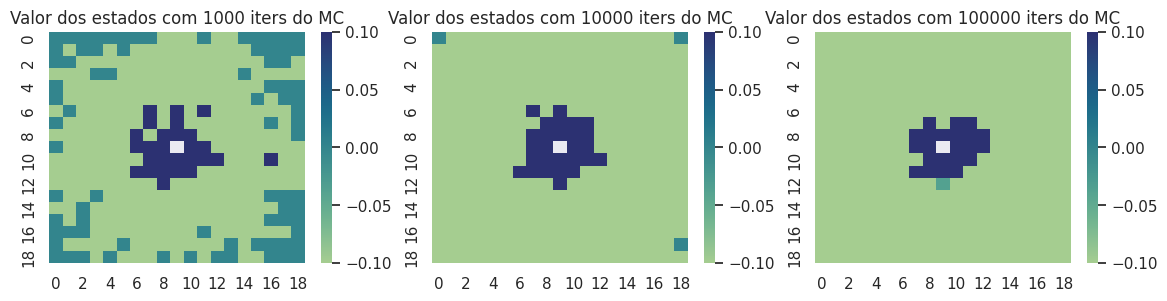

In [114]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for i, n in enumerate([1000, 10000, 100000]):
  with open(f'/content/value_function_{n}runs.pkl', 'rb') as fp:
    value_function = pickle.load(fp)

  matrix_values = np.zeros((19, 19))
  for k in list(agent.value_function.keys()):
    x = int(k.split(',')[0].split('(')[1])
    y = int(k.split(',')[1].split(')')[0])

    matrix_values[x+9][y+9] = value_function[k]

  sns.heatmap(matrix_values, ax = axs[i], cmap="crest")
  axs[i].set_title(f'Valor dos estados com {n} iters do MC')